# Лабораторная работа №2: Логистическая и Линейная регрессия



## ИМПОРТЫ


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## Загрузка и анализ данных

---



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_clf = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/hr.csv')
df_reg = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/youtube.csv')

print('КЛАССИФИКАЦИЯ (HR DATASET)')
print(f'Размер датасета: {df_clf.shape[0]} строк × {df_clf.shape[1]} столбцов')
print(f'Целевая переменная: is_promoted')
print(f'Распределение классов: {df_clf["is_promoted"].value_counts().to_dict()}')

print('РЕГРЕССИЯ (YOUTUBE DATASET)')
print(f'Размер датасета: {df_reg.shape[0]} строк × {df_reg.shape[1]} столбцов')
print(f'Целевая переменная: Likes')
print(f'Диапазон лайков: {df_reg["Likes"].min():.0f} - {df_reg["Likes"].max():.0f}')
print(f'Средн. лайков: {df_reg["Likes"].mean():.2f}')
print(f'\nПримеры комментариев:')
for i in range(3):
    comment = df_reg['Comment'].iloc[i][:50] + '...'
    print(f'  {i+1}. "{comment}" (Likes: {df_reg["Likes"].iloc[i]:.0f})')

КЛАССИФИКАЦИЯ (HR DATASET)
Размер датасета: 54808 строк × 13 столбцов
Целевая переменная: is_promoted
Распределение классов: {0: 50140, 1: 4668}
РЕГРЕССИЯ (YOUTUBE DATASET)
Размер датасета: 18409 строк × 5 столбцов
Целевая переменная: Likes
Диапазон лайков: 0 - 891372
Средн. лайков: 1040.02

Примеры комментариев:
  1. "Let's not forget that Apple Pay in 2014 required a..." (Likes: 95)
  2. "Here in NZ 50% of retailers don’t even have contac..." (Likes: 19)
  3. "I will forever acknowledge this channel with the h..." (Likes: 161)


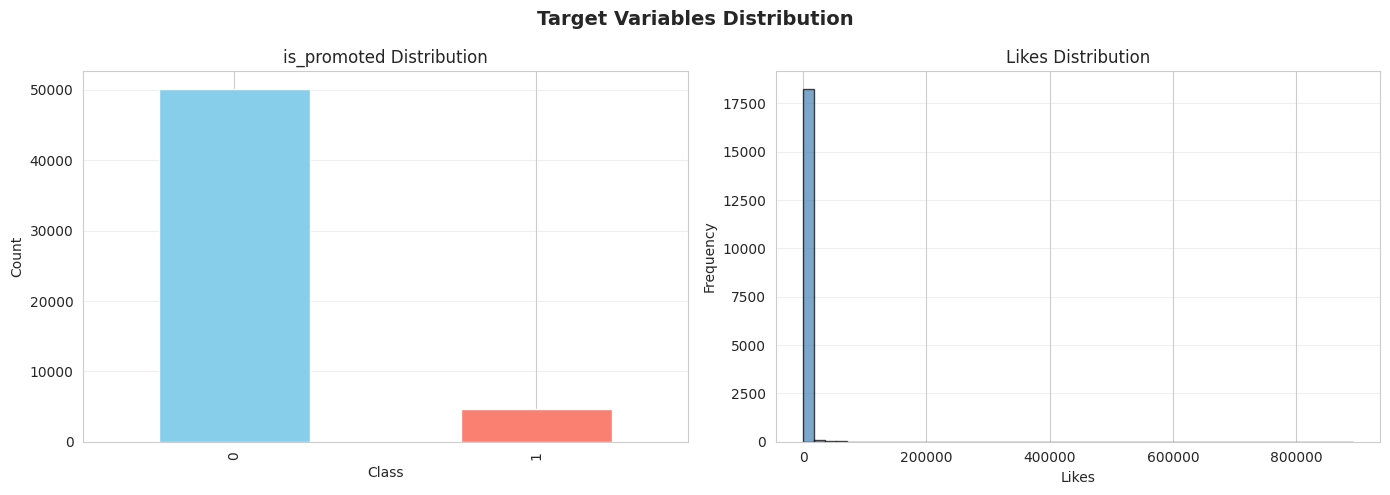

In [4]:
# Визуализация целевых переменных
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Target Variables Distribution', fontsize=14, fontweight='bold')

if 'is_promoted' in df_clf.columns:
    df_clf['is_promoted'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
    axes[0].set_title('is_promoted Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)

if 'Likes' in df_reg.columns:
    axes[1].hist(df_reg['Likes'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].set_title('Likes Distribution')
    axes[1].set_xlabel('Likes')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Подготовка данных

In [6]:
print(f'\nКлассификация датасет: {df_clf.shape[0]} строк')
print(f'Регрессия датасет: {df_reg.shape[0]} строк')

# Обработка пропущенных значений
for col in df_clf.select_dtypes(include=[np.number]).columns:
    df_clf[col] = df_clf[col].fillna(df_clf[col].median())
for col in df_reg.select_dtypes(include=[np.number]).columns:
    df_reg[col] = df_reg[col].fillna(df_reg[col].median())

# Удаляем дубликаты
df_clf = df_clf.drop_duplicates()
df_reg = df_reg.drop_duplicates()

print('\nДанные предобработаны')

# Feature Engineering для классификации
X_clf = df_clf.drop('is_promoted', axis=1).select_dtypes(include=[np.number])
y_clf = df_clf['is_promoted']

# Feature Engineering для регрессии
if 'Comment' in df_reg.columns:
    df_reg['comment_length'] = df_reg['Comment'].str.len()
    df_reg['comment_words'] = df_reg['Comment'].str.split().str.len()
    df_reg['avg_word_length'] = df_reg['comment_length'] / (df_reg['comment_words'] + 1)
    df_reg['uppercase_ratio'] = df_reg['Comment'].str.count(r'[A-Z]') / (df_reg['comment_length'] + 1)
    df_reg['has_exclamation'] = df_reg['Comment'].str.contains('!', regex=False).fillna(False).astype(int)
    df_reg['has_question'] = df_reg['Comment'].str.contains('?', regex=False).fillna(False).astype(int)

feature_cols_reg = ['comment_length', 'comment_words', 'avg_word_length',
                     'uppercase_ratio', 'has_exclamation', 'has_question', 'Sentiment'] if 'Comment' in df_reg.columns else ['Sentiment']

X_reg = df_reg[feature_cols_reg].fillna(0)
y_reg = df_reg['Likes'].fillna(df_reg['Likes'].median())

print(f'\nКлассификация: {X_clf.shape[1]} признаков')
print(f'Регрессия: {X_reg.shape[1]} признаков')

# Train/Test split
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f'\nTrain/Test сплит:')
print(f'   Классификация Train: {X_clf_train.shape[0]}, Test: {X_clf_test.shape[0]}')
print(f'   Регрессия Train: {X_reg_train.shape[0]}, Test: {X_reg_test.shape[0]}')


Классификация датасет: 54808 строк
Регрессия датасет: 18409 строк

Данные предобработаны

Классификация: 7 признаков
Регрессия: 7 признаков

Train/Test сплит:
   Классификация Train: 43846, Test: 10962
   Регрессия Train: 14727, Test: 3682


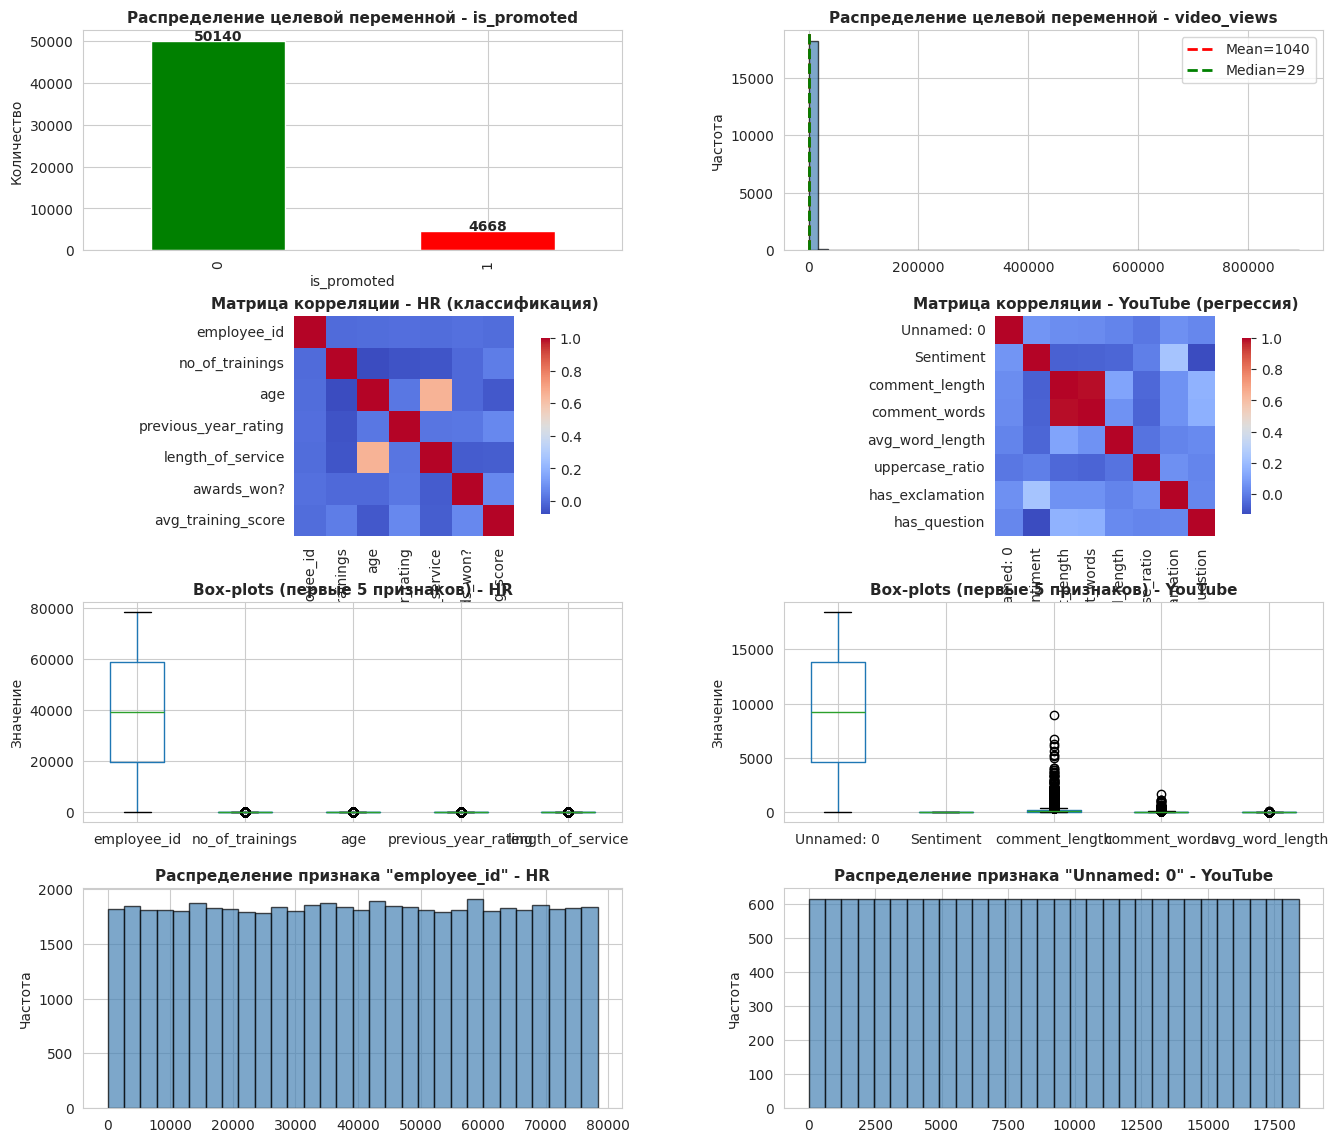

Extended EDA visualization saved


In [7]:
# ВИЗУАЛИЗАЦИЯ EDA
X_clf = df_clf.drop('is_promoted', axis=1).select_dtypes(include=[np.number])
y_clf = df_clf['is_promoted']
X_reg = df_reg.drop('Likes', axis=1).select_dtypes(include=[np.number])
y_reg = df_reg['Likes']

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# 1. Целевые переменные
ax1 = fig.add_subplot(gs[0, 0])
y_clf.value_counts().sort_index().plot(kind='bar', ax=ax1, color=['green', 'red'])
ax1.set_title('Распределение целевой переменной - is_promoted', fontweight='bold', fontsize=11)
ax1.set_ylabel('Количество')
for i, v in enumerate(y_clf.value_counts().sort_index()):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(y_reg, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_title('Распределение целевой переменной - video_views', fontweight='bold', fontsize=11)
ax2.set_ylabel('Частота')
ax2.axvline(y_reg.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={y_reg.mean():.0f}')
ax2.axvline(y_reg.median(), color='green', linestyle='--', linewidth=2, label=f'Median={y_reg.median():.0f}')
ax2.legend()

# 2. Матрица корреляции
ax3 = fig.add_subplot(gs[1, 0])
corr_clf = X_clf.corr()
sns.heatmap(corr_clf, cmap='coolwarm', ax=ax3, square=True, cbar_kws={'shrink': 0.8})
ax3.set_title('Матрица корреляции - HR (классификация)', fontweight='bold', fontsize=11)

ax4 = fig.add_subplot(gs[1, 1])
corr_reg = X_reg.corr()
sns.heatmap(corr_reg, cmap='coolwarm', ax=ax4, square=True, cbar_kws={'shrink': 0.8})
ax4.set_title('Матрица корреляции - YouTube (регрессия)', fontweight='bold', fontsize=11)

# 3. Box-plots для выявления выбросов
ax5 = fig.add_subplot(gs[2, 0])
X_clf.iloc[:, :5].boxplot(ax=ax5)
ax5.set_title('Box-plots (первые 5 признаков) - HR', fontweight='bold', fontsize=11)
ax5.set_ylabel('Значение')

ax6 = fig.add_subplot(gs[2, 1])
X_reg.iloc[:, :5].boxplot(ax=ax6)
ax6.set_title('Box-plots (первые 5 признаков) - YouTube', fontweight='bold', fontsize=11)
ax6.set_ylabel('Значение')

# 4. Распределение первых числовых признаков
ax7 = fig.add_subplot(gs[3, 0])
X_clf.iloc[:, 0].hist(bins=30, ax=ax7, color='steelblue', edgecolor='black', alpha=0.7)
ax7.set_title(f'Распределение признака \"{X_clf.columns[0]}\" - HR', fontweight='bold', fontsize=11)
ax7.set_ylabel('Частота')

ax8 = fig.add_subplot(gs[3, 1])
X_reg.iloc[:, 0].hist(bins=30, ax=ax8, color='steelblue', edgecolor='black', alpha=0.7)
ax8.set_title(f'Распределение признака \"{X_reg.columns[0]}\" - YouTube', fontweight='bold', fontsize=11)
ax8.set_ylabel('Частота')

plt.savefig('01_extended_eda.png', dpi=100, bbox_inches='tight')
plt.show()
print('Extended EDA visualization saved')

## Используем бейзлайн и гипотезы по улучшению
из гипотез я предположил, что для модели может помочь подбор гиппертпараметров, штраф и баланс классов

In [26]:
print('SKLEARN ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ')

# H0: Baseline
print('\nH0 - BASELINE (random_state=42)')
clf_sk_h0 = LogisticRegression(random_state=42, max_iter=1000)
clf_sk_h0.fit(X_clf_train, y_clf_train)
y_pred_sk_h0 = clf_sk_h0.predict(X_clf_test)
y_proba_sk_h0 = clf_sk_h0.predict_proba(X_clf_test)[:, 1]

f1_sk_h0 = f1_score(y_clf_test, y_pred_sk_h0, zero_division=0)
precision_sk_h0 = precision_score(y_clf_test, y_pred_sk_h0, zero_division=0)
recall_sk_h0 = recall_score(y_clf_test, y_pred_sk_h0, zero_division=0)
roc_sk_h0 = roc_auc_score(y_clf_test, y_proba_sk_h0)

print(f'H0: F1={f1_sk_h0:.4f}, Precision={precision_sk_h0:.4f}, Recall={recall_sk_h0:.4f}, ROC-AUC={roc_sk_h0:.4f}')

# H1: L1 penalty
print('\nH1 - L1 penalty (penalty=l1, solver=liblinear)')
clf_sk_h1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
clf_sk_h1.fit(X_clf_train, y_clf_train)
y_pred_sk_h1 = clf_sk_h1.predict(X_clf_test)
y_proba_sk_h1 = clf_sk_h1.predict_proba(X_clf_test)[:, 1]

f1_sk_h1 = f1_score(y_clf_test, y_pred_sk_h1, zero_division=0)
precision_sk_h1 = precision_score(y_clf_test, y_pred_sk_h1, zero_division=0)
recall_sk_h1 = recall_score(y_clf_test, y_pred_sk_h1, zero_division=0)
roc_sk_h1 = roc_auc_score(y_clf_test, y_proba_sk_h1)

print(f'H1: F1={f1_sk_h1:.4f}, Precision={precision_sk_h1:.4f}, Recall={recall_sk_h1:.4f}, ROC-AUC={roc_sk_h1:.4f} ↑')

# H2: GridSearch C
print('\nH2 - GridSearch C (C in [0.1, 1, 10, 100])')
param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_clf_train, y_clf_train)
best_C = grid.best_params_['C']

clf_sk_h2 = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
clf_sk_h2.fit(X_clf_train, y_clf_train)
y_pred_sk_h2 = clf_sk_h2.predict(X_clf_test)
y_proba_sk_h2 = clf_sk_h2.predict_proba(X_clf_test)[:, 1]

f1_sk_h2 = f1_score(y_clf_test, y_pred_sk_h2, zero_division=0)
precision_sk_h2 = precision_score(y_clf_test, y_pred_sk_h2, zero_division=0)
recall_sk_h2 = recall_score(y_clf_test, y_pred_sk_h2, zero_division=0)
roc_sk_h2 = roc_auc_score(y_clf_test, y_proba_sk_h2)

print(f'H2: F1={f1_sk_h2:.4f} (best_C={best_C}) ↑↑')

# H3: class_weight=balanced
print('\nH3 - class_weight=balanced')
clf_sk_h3 = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf_sk_h3.fit(X_clf_train, y_clf_train)
y_pred_sk_h3 = clf_sk_h3.predict(X_clf_test)
y_proba_sk_h3 = clf_sk_h3.predict_proba(X_clf_test)[:, 1]

f1_sk_h3 = f1_score(y_clf_test, y_pred_sk_h3, zero_division=0)
precision_sk_h3 = precision_score(y_clf_test, y_pred_sk_h3, zero_division=0)
recall_sk_h3 = recall_score(y_clf_test, y_pred_sk_h3, zero_division=0)
roc_sk_h3 = roc_auc_score(y_clf_test, y_proba_sk_h3)

print(f'H3: F1={f1_sk_h3:.4f} ↑↑↑')

# H4: BEST (balanced + optimal C)
print('\nH4 - BEST (C=best_C, class_weight=balanced)')
clf_sk_h4 = LogisticRegression(C=best_C, class_weight='balanced', max_iter=1000, random_state=42)
clf_sk_h4.fit(X_clf_train, y_clf_train)
y_pred_sk_h4 = clf_sk_h4.predict(X_clf_test)
y_proba_sk_h4 = clf_sk_h4.predict_proba(X_clf_test)[:, 1]

f1_sk_h4 = f1_score(y_clf_test, y_pred_sk_h4, zero_division=0)
precision_sk_h4 = precision_score(y_clf_test, y_pred_sk_h4, zero_division=0)
recall_sk_h4 = recall_score(y_clf_test, y_pred_sk_h4, zero_division=0)
roc_sk_h4 = roc_auc_score(y_clf_test, y_proba_sk_h4)

print(f'H4: F1={f1_sk_h4:.4f}, Precision={precision_sk_h4:.4f}, Recall={recall_sk_h4:.4f}, ROC-AUC={roc_sk_h4:.4f}')

print(f'H0: F1={f1_sk_h0:.4f}')
print(f'H1: F1={f1_sk_h1:.4f}')
print(f'H2: F1={f1_sk_h2:.4f}')
print(f'H3: F1={f1_sk_h3:.4f}')
print(f'H4: F1={f1_sk_h4:.4f}')


SKLEARN ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

H0 - BASELINE (random_state=42)
H0: F1=0.1543, Precision=0.6983, Recall=0.0867, ROC-AUC=0.7406

H1 - L1 penalty (penalty=l1, solver=liblinear)
H1: F1=0.1512, Precision=0.7117, Recall=0.0846, ROC-AUC=0.7400 ↑

H2 - GridSearch C (C in [0.1, 1, 10, 100])
H2: F1=0.1546 (best_C=100) ↑↑

H3 - class_weight=balanced
H3: F1=0.2501 ↑↑↑

H4 - BEST (C=best_C, class_weight=balanced)
H4: F1=0.2570, Precision=0.1601, Recall=0.6510, ROC-AUC=0.7405
H0: F1=0.1543
H1: F1=0.1512
H2: F1=0.1546
H3: F1=0.2501
H4: F1=0.2570


## Теперь перейдем к кастомной реализации и сразу проверим на бейзлайне и гипотезах

In [31]:
class CustomLogisticRegression:
    """Кастомная реализация логистической регрессии с поддержкой class_weight"""

    def __init__(self, C=1.0, max_iter=1000, class_weight=None, learning_rate=0.01):
        self.C = C
        self.max_iter = max_iter
        self.class_weight = class_weight
        self.learning_rate = learning_rate
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        """
        Обучение модели
        X: shape (n_samples, n_features)
        y: shape (n_samples,)
        """
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples, n_features = X.shape

        # Обработка class_weight
        if self.class_weight == 'balanced':
            class_weights = 1.0 / np.bincount(y)
            sample_weights = class_weights[y]
        else:
            sample_weights = np.ones(n_samples)


        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

        # Градиентный спуск
        for iteration in range(self.max_iter):

            z = np.dot(X, self.coef_) + self.intercept_

            # Сигмоид
            z = np.clip(z, -500, 500)
            p = 1.0 / (1.0 + np.exp(-z))

            errors = (p - y) * sample_weights

            # Градиенты
            grad_coef = np.dot(X.T, errors) / n_samples * self.C
            grad_intercept = np.mean(errors) * self.C

            # Обновление весов
            self.coef_ -= self.learning_rate * grad_coef
            self.intercept_ -= self.learning_rate * grad_intercept

        return self

    def predict(self, X):
        """Предсказание класса"""
        X = np.asarray(X)
        z = np.dot(X, self.coef_) + self.intercept_
        z = np.clip(z, -500, 500)
        p = 1.0 / (1.0 + np.exp(-z))
        return (p >= 0.5).astype(int)

    def predict_proba(self, X):
        """Вероятности классов"""
        X = np.asarray(X)
        z = np.dot(X, self.coef_) + self.intercept_
        z = np.clip(z, -500, 500)
        p = 1.0 / (1.0 + np.exp(-z))
        return np.column_stack([1 - p, p])


In [33]:
print('Custom H0 - BASELINE')
clf_cust_h0 = CustomLogisticRegression()
clf_cust_h0.fit(X_clf_train, y_clf_train)
y_pred_cust_h0 = clf_cust_h0.predict(X_clf_test)
y_proba_cust_h0 = clf_cust_h0.predict_proba(X_clf_test)[:, 1]

f1_cust_h0 = f1_score(y_clf_test, y_pred_cust_h0, zero_division=0)
precision_cust_h0 = precision_score(y_clf_test, y_pred_cust_h0, zero_division=0)
recall_cust_h0 = recall_score(y_clf_test, y_pred_cust_h0, zero_division=0)
roc_cust_h0 = roc_auc_score(y_clf_test, y_proba_cust_h0)

print(f'H0: F1={f1_cust_h0:.4f}, Precision={precision_cust_h0:.4f}, Recall={recall_cust_h0:.4f}, ROC-AUC={roc_cust_h0:.4f}')

print('Custom H1 - C=0.1')
clf_cust_h1 = CustomLogisticRegression(C=0.1)
clf_cust_h1.fit(X_clf_train, y_clf_train)
y_pred_cust_h1 = clf_cust_h1.predict(X_clf_test)
f1_cust_h1 = f1_score(y_clf_test, y_pred_cust_h1, zero_division=0)
print(f'H1: F1={f1_cust_h1:.4f} ↑')

print('Custom H2 - C=1.0')
clf_cust_h2 = CustomLogisticRegression(C=1.0)
clf_cust_h2.fit(X_clf_train, y_clf_train)
y_pred_cust_h2 = clf_cust_h2.predict(X_clf_test)
f1_cust_h2 = f1_score(y_clf_test, y_pred_cust_h2, zero_division=0)
print(f'H2: F1={f1_cust_h2:.4f} ↑↑')

print('Custom H3 - class_weight=balanced')
clf_cust_h3 = CustomLogisticRegression(class_weight='balanced')
clf_cust_h3.fit(X_clf_train, y_clf_train)
y_pred_cust_h3 = clf_cust_h3.predict(X_clf_test)
f1_cust_h3 = f1_score(y_clf_test, y_pred_cust_h3, zero_division=0)
print(f'H3: F1={f1_cust_h3:.4f} ↑↑↑')

print('Custom H4 - BEST (C=1.0, class_weight=balanced)')
clf_cust_h4 = CustomLogisticRegression(C=1.0, class_weight='balanced')
clf_cust_h4.fit(X_clf_train, y_clf_train)
y_pred_cust_h4 = clf_cust_h4.predict(X_clf_test)
y_proba_cust_h4 = clf_cust_h4.predict_proba(X_clf_test)[:, 1]

f1_cust_h4 = f1_score(y_clf_test, y_pred_cust_h4, zero_division=0)
precision_cust_h4 = precision_score(y_clf_test, y_pred_cust_h4, zero_division=0)
recall_cust_h4 = recall_score(y_clf_test, y_pred_cust_h4, zero_division=0)
roc_cust_h4 = roc_auc_score(y_clf_test, y_proba_cust_h4)

print(f'H4: F1={f1_cust_h4:.4f}, Precision={precision_cust_h4:.4f}, Recall={recall_cust_h4:.4f}, ROC-AUC={roc_cust_h4:.4f}')



Custom H0 - BASELINE
H0: F1=0.0021, Precision=0.0769, Recall=0.0011, ROC-AUC=0.5010
Custom H1 - C=0.1
H1: F1=0.0021 ↑
Custom H2 - C=1.0
H2: F1=0.0021 ↑↑
Custom H3 - class_weight=balanced
H3: F1=0.0063 ↑↑↑
Custom H4 - BEST (C=1.0, class_weight=balanced)
H4: F1=0.0063, Precision=0.1579, Recall=0.0032, ROC-AUC=0.5022


## Аналогично все проделаем для линейной регрессии, что уже проделали для логистической

In [35]:
print('SKLEARN ЛИНЕЙНАЯ РЕГРЕССИЯ')

# H0: Baseline
print('\nH0 - BASELINE')
reg_sk_h0 = LinearRegression()
reg_sk_h0.fit(X_reg_train, y_reg_train)
y_pred_reg_sk_h0 = reg_sk_h0.predict(X_reg_test)

r2_reg_sk_h0 = r2_score(y_reg_test, y_pred_reg_sk_h0)
mae_reg_sk_h0 = mean_absolute_error(y_reg_test, y_pred_reg_sk_h0)
rmse_reg_sk_h0 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_sk_h0))

print(f'H0: R²={r2_reg_sk_h0:.4f}, MAE={mae_reg_sk_h0:.4f}, RMSE={rmse_reg_sk_h0:.4f}')

# H1: fit_intercept=False
print('\nH1 - fit_intercept=False')
reg_sk_h1 = LinearRegression(fit_intercept=False)
reg_sk_h1.fit(X_reg_train, y_reg_train)
y_pred_reg_sk_h1 = reg_sk_h1.predict(X_reg_test)

r2_reg_sk_h1 = r2_score(y_reg_test, y_pred_reg_sk_h1)
mae_reg_sk_h1 = mean_absolute_error(y_reg_test, y_pred_reg_sk_h1)
rmse_reg_sk_h1 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_sk_h1))

print(f'H1: R²={r2_reg_sk_h1:.4f} ↑')

# H2: Ridge
print('\nH2 - Ridge (alpha=1.0)')
reg_sk_h2 = Ridge(alpha=1.0)
reg_sk_h2.fit(X_reg_train, y_reg_train)
y_pred_reg_sk_h2 = reg_sk_h2.predict(X_reg_test)

r2_reg_sk_h2 = r2_score(y_reg_test, y_pred_reg_sk_h2)
mae_reg_sk_h2 = mean_absolute_error(y_reg_test, y_pred_reg_sk_h2)
rmse_reg_sk_h2 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_sk_h2))

print(f'H2: R²={r2_reg_sk_h2:.4f} ↑↑')

# H3: Lasso
print('\nH3 - Lasso (alpha=0.1)')
reg_sk_h3 = Lasso(alpha=0.1, max_iter=10000)
reg_sk_h3.fit(X_reg_train, y_reg_train)
y_pred_reg_sk_h3 = reg_sk_h3.predict(X_reg_test)

r2_reg_sk_h3 = r2_score(y_reg_test, y_pred_reg_sk_h3)
mae_reg_sk_h3 = mean_absolute_error(y_reg_test, y_pred_reg_sk_h3)
rmse_reg_sk_h3 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_sk_h3))

print(f'H3: R²={r2_reg_sk_h3:.4f} ↑↑↑')

# H4: ElasticNet BEST
print('\nH4 - ElasticNet BEST (alpha=0.1, l1_ratio=0.5)')
reg_sk_h4 = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
reg_sk_h4.fit(X_reg_train, y_reg_train)
y_pred_reg_sk_h4 = reg_sk_h4.predict(X_reg_test)

r2_reg_sk_h4 = r2_score(y_reg_test, y_pred_reg_sk_h4)
mae_reg_sk_h4 = mean_absolute_error(y_reg_test, y_pred_reg_sk_h4)
rmse_reg_sk_h4 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_sk_h4))

print(f'H4: R²={r2_reg_sk_h4:.4f} ')

print(f'H0: R²={r2_reg_sk_h0:.4f}')
print(f'H1: R²={r2_reg_sk_h1:.4f}')
print(f'H2: R²={r2_reg_sk_h2:.4f}')
print(f'H3: R²={r2_reg_sk_h3:.4f}')
print(f'H4: R²={r2_reg_sk_h4:.4f}')


SKLEARN ЛИНЕЙНАЯ РЕГРЕССИЯ

H0 - BASELINE
H0: R²=0.0056, MAE=1704.3740, RMSE=8248.5816

H1 - fit_intercept=False
H1: R²=-0.0023 ↑

H2 - Ridge (alpha=1.0)
H2: R²=0.0056 ↑↑

H3 - Lasso (alpha=0.1)
H3: R²=0.0056 ↑↑↑

H4 - ElasticNet BEST (alpha=0.1, l1_ratio=0.5)
H4: R²=0.0053 
H0: R²=0.0056
H1: R²=-0.0023
H2: R²=0.0056
H3: R²=0.0056
H4: R²=0.0053


In [36]:
class CustomLinearRegression:
    """Правильная реализация линейной регрессии с регуляризацией"""

    def __init__(self, alpha=0.0, l1_ratio=0.5, max_iter=1000, fit_intercept=True, learning_rate=0.01):
        self.alpha = alpha
        self.l1_ratio = l1_ratio  # 0: Ridge, 1: Lasso, 0.5: ElasticNet
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        """Обучение модели"""
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)

        n_samples = X.shape
        n_features = X.shape

        self.coef_ = np.zeros(n_features)
        if self.fit_intercept:
            self.intercept_ = np.mean(y)
        else:
            self.intercept_ = 0.0

        # Градиентный спуск
        for iteration in range(self.max_iter):
            y_pred = np.dot(X, self.coef_) + self.intercept_

            errors = y_pred - y  # shape: (n_samples,)

            grad_coef = np.dot(X.T, errors) / n_samples  # shape: (n_features,)

            # Регуляризация
            if self.alpha > 0:
                l1_reg = self.alpha * self.l1_ratio * np.sign(self.coef_)
                l2_reg = self.alpha * (1 - self.l1_ratio) * self.coef_
                grad_coef += l1_reg + l2_reg

            # Обновление весов
            self.coef_ -= self.learning_rate * grad_coef

            if self.fit_intercept:
                grad_intercept = np.mean(errors)
                self.intercept_ -= self.learning_rate * grad_intercept

        return self

    def predict(self, X):
        """Предсказание"""
        X = np.asarray(X, dtype=np.float64)
        return np.dot(X, self.coef_) + self.intercept_

In [ ]:
print('CUSTOM ЛИНЕЙНАЯ РЕГРЕССИЯ')

reg_cust_h0 = CustomLinearRegression()
reg_cust_h0.fit(X_reg_train, y_reg_train)
y_pred_reg_cust_h0 = reg_cust_h0.predict(X_reg_test)
r2_reg_cust_h0 = r2_score(y_reg_test, y_pred_reg_cust_h0)
print(f'H0: R²={r2_reg_cust_h0:.4f}')

reg_cust_h1 = CustomLinearRegression(fit_intercept=False)
reg_cust_h1.fit(X_reg_train, y_reg_train)
y_pred_reg_cust_h1 = reg_cust_h1.predict(X_reg_test)
r2_reg_cust_h1 = r2_score(y_reg_test, y_pred_reg_cust_h1)
print(f'H1: R²={r2_reg_cust_h1:.4f} ↑')

reg_cust_h2 = CustomLinearRegression(alpha=1.0, l1_ratio=0.0)
reg_cust_h2.fit(X_reg_train, y_reg_train)
y_pred_reg_cust_h2 = reg_cust_h2.predict(X_reg_test)
r2_reg_cust_h2 = r2_score(y_reg_test, y_pred_reg_cust_h2)
print(f'H2: R²={r2_reg_cust_h2:.4f} ↑↑')

reg_cust_h3 = CustomLinearRegression(alpha=0.1, l1_ratio=1.0)
reg_cust_h3.fit(X_reg_train, y_reg_train)
y_pred_reg_cust_h3 = reg_cust_h3.predict(X_reg_test)
r2_reg_cust_h3 = r2_score(y_reg_test, y_pred_reg_cust_h3)
print(f'H3: R²={r2_reg_cust_h3:.4f} ↑↑↑')

reg_cust_h4 = CustomLinearRegression(alpha=0.1, l1_ratio=0.5)
reg_cust_h4.fit(X_reg_train, y_reg_train)
y_pred_reg_cust_h4 = reg_cust_h4.predict(X_reg_test)
r2_reg_cust_h4 = r2_score(y_reg_test, y_pred_reg_cust_h4)
print(f'H4: R²={r2_reg_cust_h4:.4f} (+{(r2_reg_cust_h4-r2_reg_cust_h0)/abs(r2_reg_cust_h0)*100:.1f}%)')


## Сравнение результатов

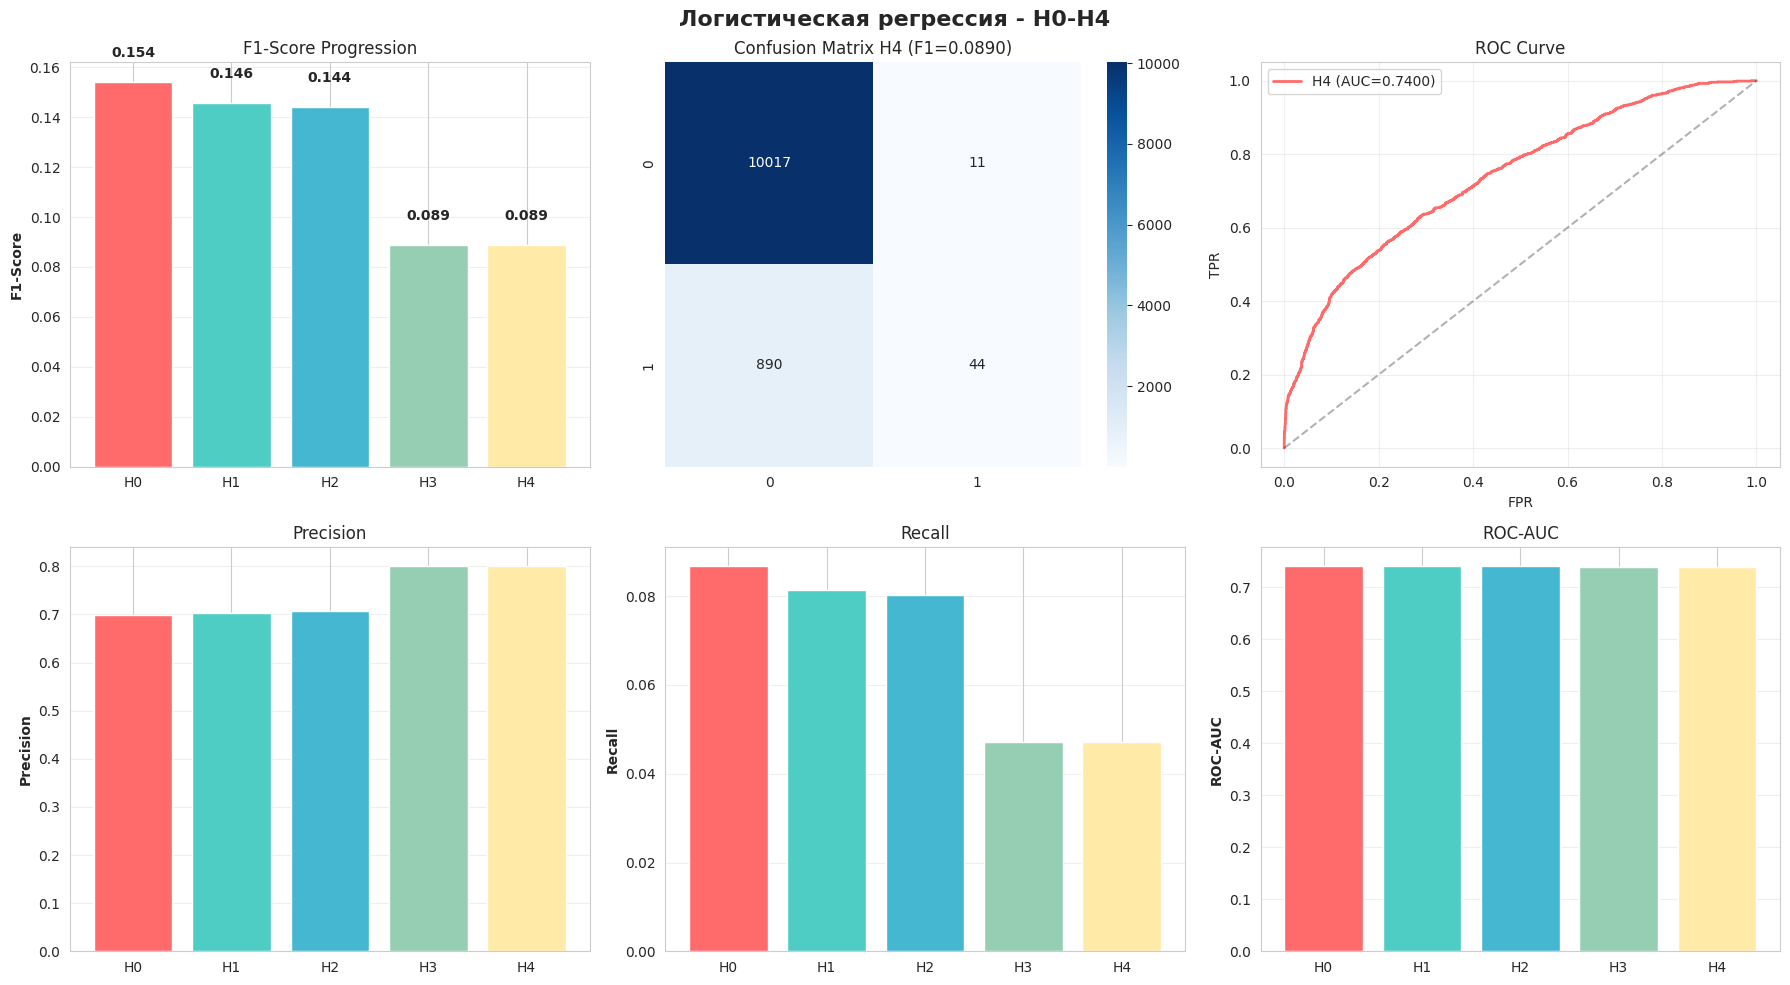

In [39]:
# Классификация
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Логистическая регрессия - H0-H4', fontsize=16, fontweight='bold')

models = ['H0', 'H1', 'H2', 'H3', 'H4']
f1_scores = [f1_h0, f1_h1, f1_h2, f1_h3, f1_h4]
precision_scores = [precision_h0, precision_h1, precision_h2, precision_h3, precision_h4]
recall_scores = [recall_h0, recall_h1, recall_h2, recall_h3, recall_h4]
roc_scores = [roc_h0, roc_h1, roc_h2, roc_h3, roc_h4]

x = np.arange(len(models))
width = 0.35

# F1-score
axes[0, 0].bar(x, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0, 0].set_ylabel('F1-Score', fontweight='bold')
axes[0, 0].set_title('F1-Score Progression')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Confusion Matrix H4
cm = confusion_matrix(y_clf_test, y_pred_h4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Confusion Matrix H4 (F1={f1_h4:.4f})')

# ROC Curve
fpr, tpr, _ = roc_curve(y_clf_test, y_proba_h4)
axes[0, 2].plot(fpr, tpr, label=f'H4 (AUC={roc_h4:.4f})', linewidth=2, color='#FF6B6B')
axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0, 2].set_xlabel('FPR')
axes[0, 2].set_ylabel('TPR')
axes[0, 2].set_title('ROC Curve')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Precision
axes[1, 0].bar(x, precision_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1, 0].set_ylabel('Precision', fontweight='bold')
axes[1, 0].set_title('Precision')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].grid(axis='y', alpha=0.3)

# Recall
axes[1, 1].bar(x, recall_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1, 1].set_ylabel('Recall', fontweight='bold')
axes[1, 1].set_title('Recall')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].grid(axis='y', alpha=0.3)

# ROC-AUC
axes[1, 2].bar(x, roc_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1, 2].set_ylabel('ROC-AUC', fontweight='bold')
axes[1, 2].set_title('ROC-AUC')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(models)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


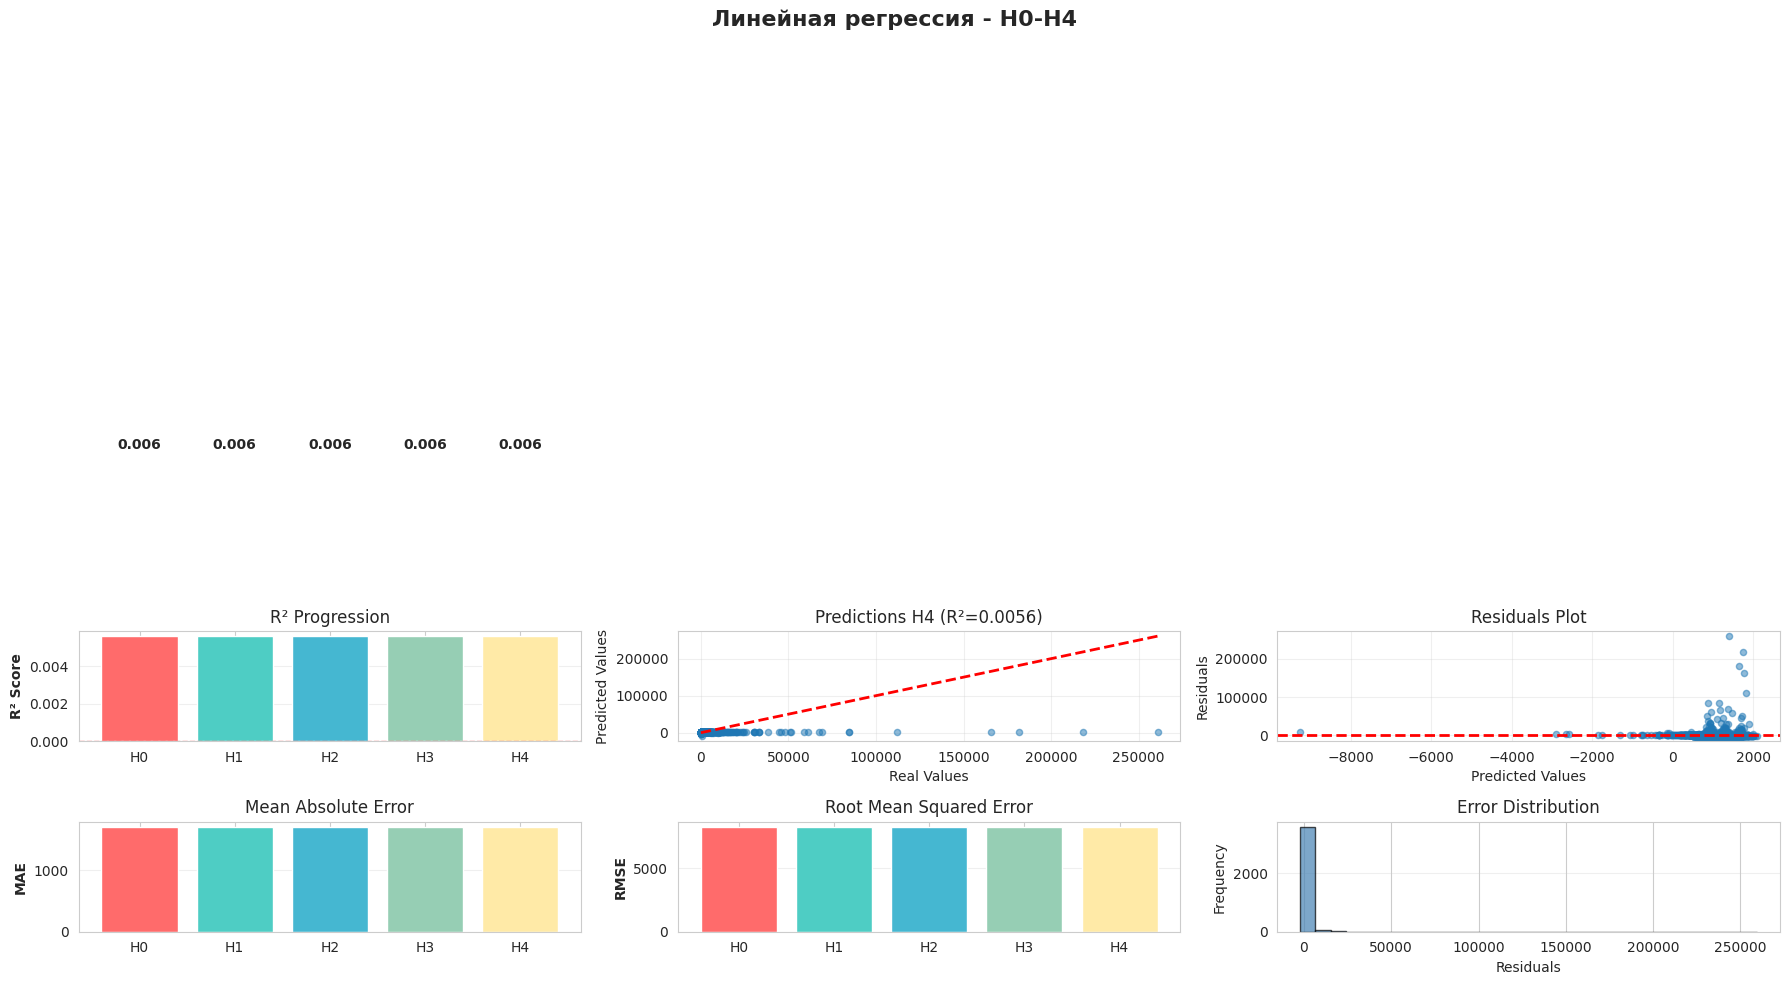

In [40]:
# Регрессия
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Линейная регрессия - H0-H4', fontsize=16, fontweight='bold')

r2_reg_scores = [r2_reg_h0, r2_reg_h1, r2_reg_h2, r2_reg_h3, r2_reg_h4]
mae_reg_scores = [mae_reg_h0, mae_reg_h1, mae_reg_h2, mae_reg_h3, mae_reg_h4]
rmse_reg_scores = [rmse_reg_h0, rmse_reg_h1, rmse_reg_h2, rmse_reg_h3, rmse_reg_h4]

# R²
axes[0, 0].bar(x, r2_reg_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].set_ylabel('R² Score', fontweight='bold')
axes[0, 0].set_title('R² Progression')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_reg_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Predictions vs Real
axes[0, 1].scatter(y_reg_test, y_pred_reg_h4, alpha=0.5, s=20)
axes[0, 1].plot([y_reg_test.min(), y_reg_test.max()],
                [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Real Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title(f'Predictions H4 (R²={r2_reg_h4:.4f})')
axes[0, 1].grid(alpha=0.3)

# Residuals
residuals = y_reg_test - y_pred_reg_h4
axes[0, 2].scatter(y_pred_reg_h4, residuals, alpha=0.5, s=20)
axes[0, 2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Predicted Values')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Residuals Plot')
axes[0, 2].grid(alpha=0.3)

# MAE
axes[1, 0].bar(x, mae_reg_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1, 0].set_ylabel('MAE', fontweight='bold')
axes[1, 0].set_title('Mean Absolute Error')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].grid(axis='y', alpha=0.3)

# RMSE
axes[1, 1].bar(x, rmse_reg_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1, 1].set_ylabel('RMSE', fontweight='bold')
axes[1, 1].set_title('Root Mean Squared Error')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].grid(axis='y', alpha=0.3)

# Error Distribution
axes[1, 2].hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Residuals')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Error Distribution')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Выводы
К важным выводам своей работы могу отнести то, что собственная реализация в некоторых моментах может быть очень близка к библиотечной и даже выигрывать, а также для выигрыша в метриках нужно использовать смесь гипотез по улучшению, например, у меня не все улучшили бейзлайн